In [63]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Config

import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from pathlib import Path
import numpy as np
from PIL import Image
import os
from math import ceil

In [64]:
VOCAB_SIZE = 30000
MAX_LEN = 128

In [65]:
TOKENIZER_SAVEDIR = Path('/home/macosta/ttmp/primus-data/blocks/blocks-v3-tokenizer/')
LM_MODEL_SAVEDIR = Path('/home/macosta/ttmp/primus-models/gpt2-lm-blocks-nocols/')
PRIMUS_TXT_FILES = Path('/home/ibukey/ttmp/blocks-txt-v3/')

In [66]:
config = GPT2Config(
    vocab_size=VOCAB_SIZE,
    n_positions=MAX_LEN,
    n_head=12,
)

In [67]:
model = GPT2LMHeadModel(config=config).from_pretrained(str(LM_MODEL_SAVEDIR))

In [68]:
tokenizer = GPT2TokenizerFast.from_pretrained(TOKENIZER_SAVEDIR, max_len=MAX_LEN)

file /home/macosta/ttmp/primus-data/blocks/blocks-v3-tokenizer/config.json not found
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [77]:
def tokens_to_image(tokens):
    tokens = [t for t in tokens if t not in ["<s>", "</s>", "<pad>"]]
    img_array = np.ones((15 * 6 + 5 * 3, ceil(len(tokens) / 6)*15), dtype=np.uint8) * 255
    for i in range(5):
        img_array[i*18+15:(i*18)+3+15, :] = 0
    for i, token in enumerate(tokens):
        if token == '<unk>':
            token_np = UNK_TOKEN
        else:
            token_np = np.array([int(x) for x in token]).reshape((15, 15))
            token_np = token_np * 255
        row = i % 6
        column = i // 6
        start_row = row * 18
        start_column = column * 15
        img_array[start_row:start_row+15, start_column:start_column+15] = token_np
        img = Image.fromarray(img_array)
    return img

In [74]:
tokenizer.encode('<unk>')

[3]

In [83]:
UNK_TOKEN = ''.join(["0" if i % 2 else "1" for i in range(225)])

In [99]:
def continue_image(max_len=512, show=True, show_original=True, temp=1):
#     with open(file, 'r') as f:
#         data = f.read()
#     tokens = data.split()
#     index = int(np.random.random()*(len(tokens) - seed_length))
#     index = (index // 4) * 4
#     seed = tokens[index:index + seed_length]
#     if show_original:
#         tokens_to_image(seed).show()
#         tokens_to_image(tokens[index:index + max_len]).show()
#     input_string = f"{' '.join(seed[-(max_len - 1):])}"
    input_string = '<s>'
    inputs = tokenizer.encode(input_string, return_tensors="pt")
    output_tokens = model.generate(inputs, 
                                   min_length=max_len,
                                   max_length=max_len, 
                                   pad_token_id=1,
                                   eos_token_id=2,
                                   temperature=temp,
                                   do_sample=True,
                                   bad_words_ids=[[3]])[0]
    output_tokens = tokenizer.decode(output_tokens).split()
    output_tokens = [UNK_TOKEN if t == '<unk>' else t for t in output_tokens if t not in ['<s>', '</s>', '<pad>']]
    img = tokens_to_image(output_tokens)
    if show:
        img.show()
    return img

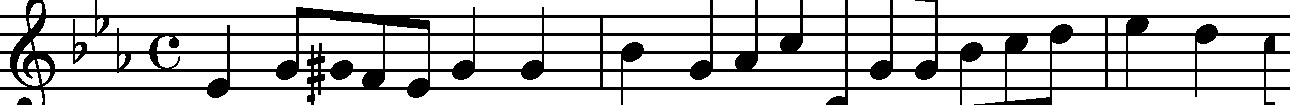

In [98]:
img = continue_image()

In [100]:
def generate_incipits(N, savedir):
    savedir.mkdir(exist_ok=True)
    for i in range(N):
        img = continue_image(show=False)
        img.save(savedir / f"generated_{i}.png")

In [101]:
generate_incipits(30, Path('/home/macosta/ttmp/generated-blockwise-v2'))